In [45]:
import os
import re
from tqdm import tqdm
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Dropout, LSTM, Embedding, Bidirectional, GRU, SpatialDropout1D
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping
from sklearn.model_selection import train_test_split
from keras.layers import Embedding
from  keras . utils  import  to_categorical
from keras.layers import Dense, Input, GlobalMaxPooling1D
from keras.layers import Conv1D,Conv2D, MaxPooling1D, Embedding, Flatten
from keras.models import Model
from keras.initializers import Constant
from keras.layers import Embedding
import tensorflow as tf

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
import pandas as pd 
train_data=pd.read_csv('gdrive/My Drive/Colab Notebooks/ulm_train.csv')
stopwords=pd.read_csv('gdrive/My Drive/Colab Notebooks/Stopwords.csv')
test_data=pd.read_csv('gdrive/My Drive/Colab Notebooks/ulm_test.csv')


In [4]:
!git clone -l -s https://github.com/banglakit/bengali-stemmer.git

Cloning into 'bengali-stemmer'...
remote: Enumerating objects: 25, done.
remote: Counting objects: 100% (25/25), done.
remote: Compressing objects: 100% (17/17), done.
remote: Total 94 (delta 5), reused 16 (delta 4), pack-reused 69
Unpacking objects: 100% (94/94), done.


In [5]:
!pip install git+https://github.com/banglakit/bengali-stemmer.git    

  Cloning https://github.com/banglakit/bengali-stemmer.git to /tmp/pip-req-build-o47vvhv5
  Running command git clone -q https://github.com/banglakit/bengali-stemmer.git /tmp/pip-req-build-o47vvhv5
  Created wheel for bengali-stemmer: filename=bengali_stemmer-0.0.1-py2.py3-none-any.whl size=6393 sha256=498d45252c695578c5f9eb7fbe84a338d5fcb9798eb5b307ef502efddaab64de
  Stored in directory: /tmp/pip-ephem-wheel-cache-yw6snpip/wheels/a1/ad/a1/4ba354059b17c00600a14e13a504e7bdb49f20f2f4e2f3639c
Successfully built bengali-stemmer


In [6]:
from bengali_stemmer.rafikamal2014 import RafiStemmer
stemmer = RafiStemmer()
stemmer.stem_word('বাংলায়')

'বাংলা'

In [7]:
total_data = train_data
total_data=total_data.append(test_data, ignore_index = True)

In [8]:
macronum=sorted(set(total_data['label']))
macro_to_id = dict((note, number) for number, note in enumerate(macronum))

def fun(i):
    return macro_to_id[i]

total_data['label']=total_data['label'].apply(fun)


In [9]:
texts = list(total_data['text'])
labels = list(total_data['label'])

In [10]:
def clean_punct(sentence):
    cleaned = re.sub(r'[?|!|\'|"|#|।|’|‘]', r'', sentence)
    cleaned1 = re.sub(r'[.|,|(|)|\|/]', r'', cleaned)
    cleaned = re.sub(r'[০|১|২|৩|৪|৫|৬|৭|৮|৯]', r'', cleaned1)
    cleaned1 = re.sub(r'[-|=]', r' ', cleaned)
    return cleaned1

In [11]:
set_stop = set(stopwords['words'])

In [12]:
def pre_process(data):
    i=0
    str1=' '
    final_string = []
    final_words = []
    all_negative_words = []
    s=''

    for sentence in data:
        filtered_sentence = []

        for w in sentence.split():
            for cleaned_word in clean_punct(w).split():
                if len(cleaned_word)>2:
                    if((cleaned_word) not in set_stop):
                        s = stemmer.stem_word(cleaned_word)
                        if len(s)>2:
                            final_words.append(s)
                            filtered_sentence.append(s)
                    else:
                        continue
                else:
                    continue

        str1 = " ".join(filtered_sentence)
        final_string.append(str1)
    return final_string

In [13]:
texts = pre_process(texts)

In [14]:
texts[0]

'সাম্প্রদায়িক সংঘাত মানবিক প্রতিরোধ সাম্প্রদায়িক সংঘাত মানবিক প্রতিরোধফকির ইলিয়াস দেশ থাকি বহুজাতিক বহুভাষিক মানুষ বাস ধর্মাবলম্বী মতাবলম্বী মানুষ কারো কারো মিল চাইল সামান্য বিষ প্রতিদিন দাঙ্গা তেমন হ্যাঁ প্রি পাঠক মার্কিন যুক্তরাষ্ট্র কথা বলছিএ দেশ মানুষ মানুষ বুক পাঁজর চিবি দেশ কঠোর আইন থাক পার পারব পারব কঠিন শাস্তির মুখোমুখি জীবনবাজি রায়ট কেপাক ভারত উপমহাদেশ জন্ম বিভক্ত রায়ট মধ্য কারোর অজানা জন্মইতিহাস জন্ম পাকিস্তান ভারত পরবর্তীকাল বাংলাদেশ ভূখণ্ড দ্বিজাতি তত্ত্ব শত্রু সম্পত্তি আইন মানুষ মানুষ ধর্ম বিভাজন সেভাব পরিকল্পিতভাব সাল ভারত ভাগ অসংখ্য হিন্দু ঘরবাড়ি ছেড় গিয় জিন্নাহর দ্বিজাতি তত্ত্ব ভিত্তি ওঠা দেশ অস্তিত্ব রক্ষা প্রশ্ন প্রথম সাল পূর্বতন পূর্ব পাকিস্তান সাম্প্রদায়িক দাঙ্গ হিন্দু নিরাপত্ত পালি সাল হিন্দু আওয়ামী লীগ ভোট বিশ্বাস দখলদ পাক সেনা সহযোগী প্রবল প্রতিশোধস্পৃহা খুঁজ খুঁজ হিন্দু নিধন চালি হিন্দু বুদ্ধিজীবী সমাজসেবী শ্রদ্ধে ব্যক্তিত্ব ঢাকা বিশ্ববিদ্যালয় জগন্নাথ সহস্রাধিক হিন্দু ছাত্র হত্যা সাল নভেম্বর তারিখ ইউএস সিনেট কমি প্রামাণ্য প্রতিবেদন সিনেটর এডওয়ার্ড কেনেডি লিখ “সব

In [ ]:
def load_data(num_words, sequence_length, test_size=0.25, oov_token=None):
    tokenizer = Tokenizer(num_words=num_words, oov_token=oov_token)
    num_classes=6
    y = to_categorical(np.asarray(labels), num_classes)
    tokenizer.fit_on_texts(texts)
    X = tokenizer.texts_to_sequences(texts)
    X = np.array(X)
    # pad sequences with 0's
    X = pad_sequences(X, maxlen=sequence_length)
    # split data to training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=1)
    data = {}
    data["X_train"] = X_train
    data["X_test"]= X_test
    data["y_train"] = y_train
    data["y_test"] = y_test
    data["tokenizer"] = tokenizer
    return data

In [ ]:
# train_data=pd.read_csv('gdrive/My Drive/Colab Notebooks/ulm_train.csv')

def get_embedding_vectors(word_index, embedding_size=100):
    
    embedding_matrix = np.zeros((len(word_index) + 1, embedding_size))
    with open(f"gdrive/My Drive/Colab Notebooks/bn_glove.{embedding_size}d.txt", encoding="utf8") as f:
        for line in tqdm(f, "Reading GloVe"):
            values = line.split()
            # get the word as the first word in the line
            word = values[0]
            if word in word_index:
                idx = word_index[word]
                # get the vectors as the remaining values in the line
                embedding_matrix[idx] = np.array(values[1:], dtype="float32")
    return embedding_matrix

In [ ]:
MAX_SEQUENCE_LENGTH = 11276    #max([len(s.split()) for s in texts]) 
MAX_NUM_WORDS = 109804   # 109803 +1
vocab_size = MAX_NUM_WORDS
EMBEDDING_DIM = 300
VALIDATION_SPLIT = 0.2

data = load_data(MAX_NUM_WORDS , MAX_SEQUENCE_LENGTH,VALIDATION_SPLIT)

In [ ]:
len(data['tokenizer'].word_index)

109803

In [ ]:
embedding_matrix = get_embedding_vectors( data['tokenizer'].word_index ,EMBEDDING_DIM )

Reading GloVe: 134256it [00:08, 15355.66it/s]


In [ ]:
embedding_layer = Embedding(len(data['tokenizer'].word_index) + 1,  # or we can use 'MAX_NUM_WORDS'
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)
#model.add(Embedding(vocabulary_size, EMBEDDING_DIM, input_length=row_max_length)), find that from kaggle


In [ ]:
# define model, a simple model
model = Sequential()
model.add(embedding_layer)
#model.add(Conv1D(filters=128, kernel_size=5, activation='relu'))
#model.add(MaxPooling1D(pool_size=2))
model.add(GRU(4))
model.add(Flatten())
model.add(Dense(6, activation='softmax'))
print(model.summary())


'''
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(13, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

epochs = 5
batch_size = 64

'''

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 11276, 300)        32941200  
_________________________________________________________________
gru_1 (GRU)                  (None, 4)                 3672      
_________________________________________________________________
flatten_1 (Flatten)          (None, 4)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 30        
Total params: 32,944,902
Trainable params: 3,702
Non-trainable params: 32,941,200
_________________________________________________________________
None


"\nmodel = Sequential()\nmodel.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))\nmodel.add(SpatialDropout1D(0.2))\nmodel.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))\nmodel.add(Dense(13, activation='softmax'))\nmodel.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])\n\nepochs = 5\nbatch_size = 64\n\n"

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy']) # using adma optimizer


In [ ]:
#history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

history = model.fit(data['X_train'], data['y_train'], validation_data=(data['X_test'], data['y_test']), epochs=10, verbose=2)

Epoch 1/10
53/53 - 48s - loss: 1.7842 - accuracy: 0.1875 - val_loss: 1.7315 - val_accuracy: 0.2833
Epoch 2/10
53/53 - 48s - loss: 1.6993 - accuracy: 0.3101 - val_loss: 1.6640 - val_accuracy: 0.3381
Epoch 3/10
53/53 - 47s - loss: 1.6261 - accuracy: 0.3946 - val_loss: 1.5980 - val_accuracy: 0.3762
Epoch 4/10
53/53 - 47s - loss: 1.5557 - accuracy: 0.4506 - val_loss: 1.5375 - val_accuracy: 0.4238
Epoch 5/10
53/53 - 47s - loss: 1.4910 - accuracy: 0.4899 - val_loss: 1.4856 - val_accuracy: 0.4571
Epoch 6/10
53/53 - 47s - loss: 1.4301 - accuracy: 0.5315 - val_loss: 1.4383 - val_accuracy: 0.5095
Epoch 7/10
53/53 - 47s - loss: 1.3721 - accuracy: 0.5524 - val_loss: 1.3915 - val_accuracy: 0.5143
Epoch 8/10
53/53 - 47s - loss: 1.3183 - accuracy: 0.5524 - val_loss: 1.3555 - val_accuracy: 0.5119
Epoch 9/10
53/53 - 47s - loss: 1.2672 - accuracy: 0.5726 - val_loss: 1.3216 - val_accuracy: 0.5167
Epoch 10/10
53/53 - 47s - loss: 1.2203 - accuracy: 0.5923 - val_loss: 1.2899 - val_accuracy: 0.5286


In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
def confussion_mat(model):
    # Predict the values from the validation dataset
    Y_pred = model.predict(data['X_test'])
    # Convert predictions classes to one hot vectors 
    Y_pred_classes = np.argmax(Y_pred,axis = 1) 
    # Convert validation observations to one hot vectors
    Y_true = np.argmax(data['y_test'],axis = 1) 
    # compute the confusion matrix
    confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
    # plot the confusion matrix
    f,ax = plt.subplots(figsize=(15, 15))
    sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="Greens",linecolor="gray", fmt= '.1f',ax=ax)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

In [ ]:
def history2(history):
    # list all data in history
    print(history.history.keys())
    # summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

In [ ]:
history2(history)

In [ ]:
confussion_mat(model)

In [ ]:
# GRU with 128 units
model = Sequential()
model.add(embedding_layer)
#model.add(Conv1D(filters=128, kernel_size=5, activation='relu'))
#model.add(MaxPooling1D(pool_size=2))
model.add(SpatialDropout1D(0.2))
model.add(Bidirectional(GRU(128)))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(6, activation='softmax'))
print(model.summary())

'''
EMBEDDING_DIM = 256

model = Sequential()
model.add(SpatialDropout1D(0.2))
model.add(Bidirectional(GRU(128)))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(target_length, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=1)
history = model.fit(X_train_pad, y_train_cat, epochs=5, validation_data=(X_test_pad, y_test_cat), batch_size=128, callbacks=[callback])
'''

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 11276, 300)        32941200  
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 11276, 300)        0         
_________________________________________________________________
bidirectional (Bidirectional (None, 256)               330240    
_________________________________________________________________
dense_3 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 6)                 774       
Total params: 33,305,110
Trainable params: 363,910
Non-trainable params: 32,941,200
____________________________________

"\nEMBEDDING_DIM = 256\n\nmodel = Sequential()\nmodel.add(SpatialDropout1D(0.2))\nmodel.add(Bidirectional(GRU(128)))\nmodel.add(Dense(128, activation='relu'))\nmodel.add(Dropout(0.2))\nmodel.add(Dense(target_length, activation='softmax'))\nmodel.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])\n\ncallback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=1)\nhistory = model.fit(X_train_pad, y_train_cat, epochs=5, validation_data=(X_test_pad, y_test_cat), batch_size=128, callbacks=[callback])\n"

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy']) # using adma optimizer


In [ ]:
callback = EarlyStopping(monitor='val_loss', patience=3)
history = model.fit(data['X_train'], data['y_train'], validation_data=(data['X_test'], data['y_test']),epochs=10, batch_size=32, callbacks=[callback] , verbose=2)


Epoch 1/10
53/53 - 162s - loss: 1.4527 - accuracy: 0.4179 - val_loss: 1.1502 - val_accuracy: 0.5381
Epoch 2/10
53/53 - 162s - loss: 0.9949 - accuracy: 0.6042 - val_loss: 1.0105 - val_accuracy: 0.6000
Epoch 3/10
53/53 - 163s - loss: 0.8452 - accuracy: 0.6804 - val_loss: 0.9316 - val_accuracy: 0.6476
Epoch 4/10
53/53 - 163s - loss: 0.7564 - accuracy: 0.7161 - val_loss: 0.9070 - val_accuracy: 0.6595
Epoch 5/10
53/53 - 163s - loss: 0.6647 - accuracy: 0.7518 - val_loss: 0.8665 - val_accuracy: 0.6857
Epoch 6/10
53/53 - 163s - loss: 0.5730 - accuracy: 0.7911 - val_loss: 0.8825 - val_accuracy: 0.6595
Epoch 7/10
53/53 - 161s - loss: 0.5101 - accuracy: 0.8024 - val_loss: 0.9251 - val_accuracy: 0.6643
Epoch 8/10
53/53 - 161s - loss: 0.4553 - accuracy: 0.8375 - val_loss: 0.9433 - val_accuracy: 0.7071


In [ ]:
history = model.fit(data['X_train'], data['y_train'], validation_data=(data['X_test'], data['y_test']),epochs=2, batch_size=32, verbose=2)


Epoch 1/2
53/53 - 162s - loss: 0.4141 - accuracy: 0.8601 - val_loss: 0.8864 - val_accuracy: 0.6786
Epoch 2/2
53/53 - 162s - loss: 0.3168 - accuracy: 0.8881 - val_loss: 0.9324 - val_accuracy: 0.7238


In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
def confussion_mat(model):
    # Predict the values from the validation dataset
    Y_pred = model.predict(data['X_test'])
    # Convert predictions classes to one hot vectors 
    Y_pred_classes = np.argmax(Y_pred,axis = 1) 
    # Convert validation observations to one hot vectors
    Y_true = np.argmax(data['y_test'],axis = 1) 
    # compute the confusion matrix
    confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
    # plot the confusion matrix
    f,ax = plt.subplots(figsize=(15, 15))
    sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="Greens",linecolor="gray", fmt= '.1f',ax=ax)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

In [ ]:
def history2(history):
    # list all data in history
    print(history.history.keys())
    # summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


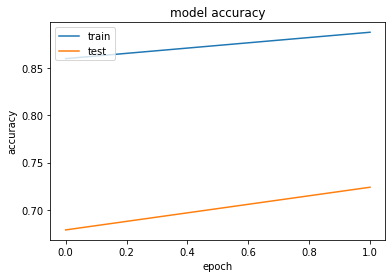

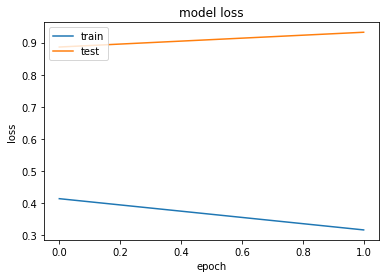

In [ ]:
history2(history)

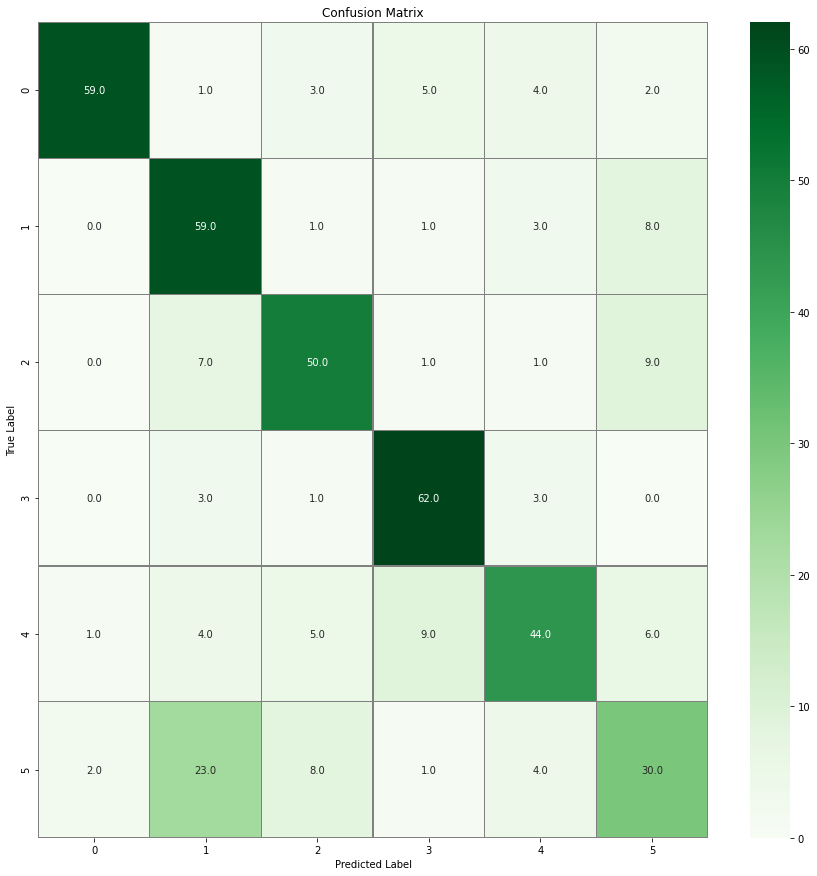

In [ ]:
confussion_mat(model)

In [ ]:
# CNN + GRU with 128 units 
model = Sequential()
model.add(embedding_layer)
model.add(Conv1D(filters=128, kernel_size=5, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(SpatialDropout1D(0.2))
model.add(Bidirectional(GRU(128)))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(6, activation='softmax'))
print(model.summary())


Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 11276, 300)        32941200  
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 11272, 128)        192128    
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 5636, 128)         0         
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 5636, 128)         0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 256)               198144    
_________________________________________________________________
dense_5 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)              

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy']) # using adma optimizer


In [ ]:
# don't run it at 10 epochs,just run it only 5 epochs
history = model.fit(data['X_train'], data['y_train'], validation_data=(data['X_test'], data['y_test']),epochs=10, batch_size=32, verbose=2)


Epoch 1/10
53/53 - 94s - loss: 1.2663 - accuracy: 0.5220 - val_loss: 0.9884 - val_accuracy: 0.6357
Epoch 2/10
53/53 - 92s - loss: 0.7584 - accuracy: 0.7179 - val_loss: 0.8455 - val_accuracy: 0.6762
Epoch 3/10
53/53 - 93s - loss: 0.5471 - accuracy: 0.8054 - val_loss: 0.8625 - val_accuracy: 0.6976
Epoch 4/10
53/53 - 93s - loss: 0.3076 - accuracy: 0.8905 - val_loss: 0.9025 - val_accuracy: 0.7071
Epoch 5/10
53/53 - 93s - loss: 0.2337 - accuracy: 0.9250 - val_loss: 0.9702 - val_accuracy: 0.6976
Epoch 6/10
53/53 - 93s - loss: 0.1627 - accuracy: 0.9494 - val_loss: 1.0688 - val_accuracy: 0.6786
Epoch 7/10
53/53 - 93s - loss: 0.1262 - accuracy: 0.9554 - val_loss: 1.1952 - val_accuracy: 0.6857
Epoch 8/10
53/53 - 93s - loss: 0.0713 - accuracy: 0.9792 - val_loss: 1.1854 - val_accuracy: 0.7119
Epoch 9/10
53/53 - 93s - loss: 0.0402 - accuracy: 0.9869 - val_loss: 1.3708 - val_accuracy: 0.7071
Epoch 10/10
53/53 - 93s - loss: 0.0552 - accuracy: 0.9827 - val_loss: 1.3727 - val_accuracy: 0.6833


In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
def confussion_mat(model):
    # Predict the values from the validation dataset
    Y_pred = model.predict(data['X_test'])
    # Convert predictions classes to one hot vectors 
    Y_pred_classes = np.argmax(Y_pred,axis = 1) 
    # Convert validation observations to one hot vectors
    Y_true = np.argmax(data['y_test'],axis = 1) 
    # compute the confusion matrix
    confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
    # plot the confusion matrix
    f,ax = plt.subplots(figsize=(15, 15))
    sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="Greens",linecolor="gray", fmt= '.1f',ax=ax)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

In [ ]:
def history2(history):
    # list all data in history
    print(history.history.keys())
    # summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


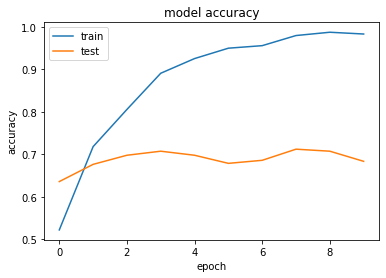

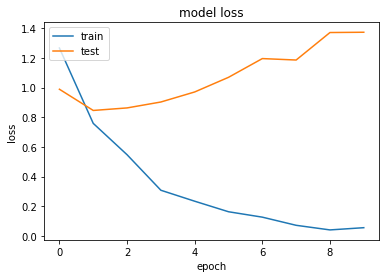

In [ ]:
history2(history)

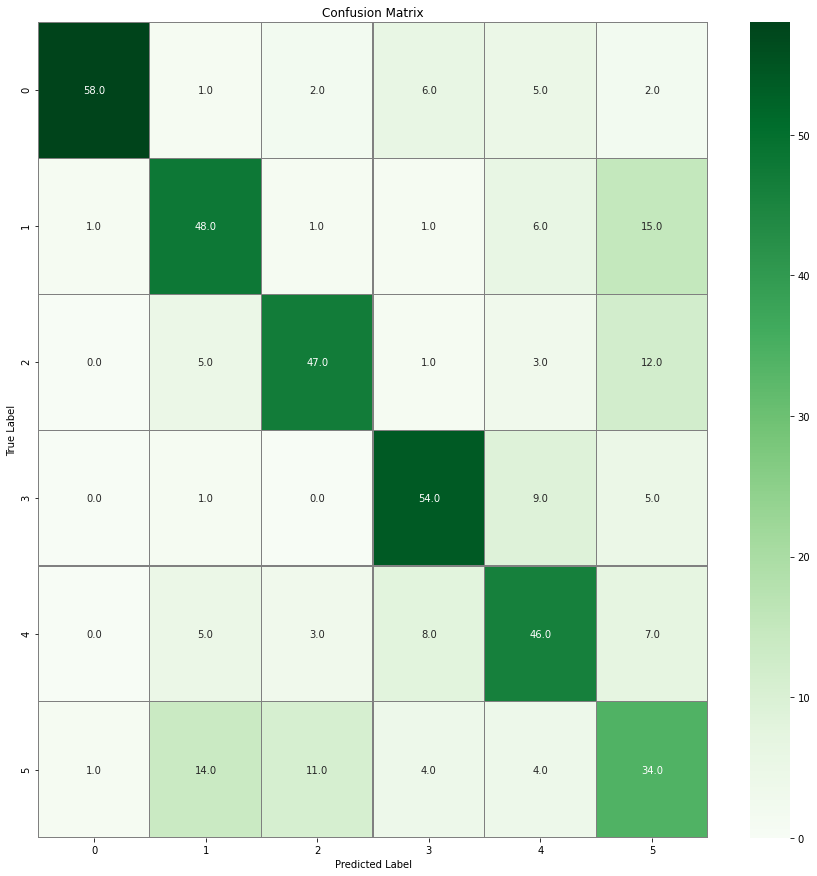

In [ ]:
confussion_mat(model)

16 authors, CNN + GRU (128 units) model

In [15]:
import pandas as pd 
train_df=pd.read_csv('gdrive/My Drive/Thesis Data/Our dataset/OurDataset_train.csv')
stopwords=pd.read_csv('gdrive/My Drive/Colab Notebooks/Stopwords.csv')
test_df=pd.read_csv('gdrive/My Drive/Thesis Data/Our dataset/OurDataset_test.csv')


In [16]:
total_df = train_df
total_df=total_df.append(test_df, ignore_index = True)

In [17]:
macronum=sorted(set(total_df['label']))
macro_to_id = dict((note, number) for number, note in enumerate(macronum))

def fun(i):
    return macro_to_id[i]

total_df['label']=total_df['label'].apply(fun)


In [18]:
texts = list(total_df['text'])
labels = list(total_df['label'])

In [19]:
def clean_punct(sentence):
    cleaned = re.sub(r'[?|!|\'|"|#|।|’|‘]', r'', sentence)
    cleaned1 = re.sub(r'[.|,|(|)|\|/]', r'', cleaned)
    cleaned = re.sub(r'[০|১|২|৩|৪|৫|৬|৭|৮|৯]', r'', cleaned1)
    cleaned1 = re.sub(r'[-|=]', r' ', cleaned)
    return cleaned1

In [20]:
set_stop = set(stopwords['words'])

def pre_process(data):
    i=0
    str1=' '
    final_string = []
    final_words = []
    all_negative_words = []
    s=''

    for sentence in data:
        filtered_sentence = []

        for w in sentence.split():
            for cleaned_word in clean_punct(w).split():
                if len(cleaned_word)>2:
                    if((cleaned_word) not in set_stop):
                        s = stemmer.stem_word(cleaned_word)
                        if len(s)>2:
                            final_words.append(s)
                            filtered_sentence.append(s)
                    else:
                        continue
                else:
                    continue

        str1 = " ".join(filtered_sentence)
        final_string.append(str1)
    return final_string

In [21]:
texts = pre_process(texts)

In [22]:
texts[0]

'দূর ভরত হেস উঠল আপন বালিকা বধূ স্কুল পাঠানো সরলা বিবির টানাটানি সরলা বেথুন স্কুল লোরে হাউজ দুজন ধারণা স্কুল ভালো বেথুন স্কুল বাঙা পাড়া বাংলা মাধ্যম লোরেটো হাউজ সাহেব পাড় ইংরেজি স্কুল বাঙা ছাত্রীর তুলনা ফিরিঙ্গি ছাত্রী বেথুন ছাত্রী সমাজ নাম মহিলা বছর বেথুন ছাত্রী হইচ প্রবেশিকা পরীক্ষা ভালোভাব উত্তীর্ণ অবলা দাস নাম মেয়ে ডাক্তারি পড়ব কলকাতা মেডিক কলেজ ছাত্রী নেয়া অবল কেনো ডাক্তারি পারব শেষ পাঠি মাদ্রাজ মেডিক কলেজ অবল জেদ বাঙলা সরক কুড়ি টাক মাসিক বৃত্তির অনুমোদন দেশ কোথা আন্দোলন বেথুন কলেজ প্রভাব ইলবার্ট বিল সাহেব দেশী মানুষ বিদ্য বুদ্ধি প্রচ লাগল কামিনী নাম তেজস্বিনী ছাত্রীর নেতৃত্ব বেথুন বিক্ষোভ জানি সুর বাড়ুজ্য যেদিন সেদিন বেথুন ছাত্রী কালো বেধ স্কুল লোরেটো হাউজ এসব স্বদেশিয়ানা নিষিদ্ধ প্রভু যিশুর জয়গান নিয়মিত প্রার্থনা ছাত্রী ভালো ইংরেজি শেখ বিলিতি আদব কায়দা রপ্ত পাস ব্যারিস্ পত্নী হিসেব মানি বিবির বয়েস বছর সরল এগারো মামা পিসতু বোন ভাব মাঝ মাঝ তর্ক বয়েস সরল ইংরেজ শাসন সম্পর্ রাগ রাগ ভাব প্রা আবৃত্তি স্বাধীনতা হীনতা বাঁচি বাঁচি বয়েসী পরিবার নিয়ম কাকিমা মামী সরলা ছুট দুজন হাত ইক

In [23]:
def load_data(num_words, sequence_length, test_size=0.25, oov_token=None):
    tokenizer = Tokenizer(num_words=num_words, oov_token=oov_token)
    num_classes=16
    y = to_categorical(np.asarray(labels), num_classes)
    tokenizer.fit_on_texts(texts)
    X = tokenizer.texts_to_sequences(texts)
    X = np.array(X)
    # pad sequences with 0's
    X = pad_sequences(X, maxlen=sequence_length)
    # split data to training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=1)
    data = {}
    data["X_train"] = X_train
    data["X_test"]= X_test
    data["y_train"] = y_train
    data["y_test"] = y_test
    data["tokenizer"] = tokenizer
    return data

In [24]:
# train_data=pd.read_csv('gdrive/My Drive/Colab Notebooks/ulm_train.csv')

def get_embedding_vectors(word_index, embedding_size=100):
    
    embedding_matrix = np.zeros((len(word_index) + 1, embedding_size))
    with open(f"gdrive/My Drive/Colab Notebooks/bn_glove.{embedding_size}d.txt", encoding="utf8") as f:
        for line in tqdm(f, "Reading GloVe"):
            values = line.split()
            # get the word as the first word in the line
            word = values[0]
            if word in word_index:
                idx = word_index[word]
                # get the vectors as the remaining values in the line
                embedding_matrix[idx] = np.array(values[1:], dtype="float32")
    return embedding_matrix

In [25]:
d = set()
for s in texts:
    for ss in list(s.split()):
        d.add(ss)

In [26]:
len(d)

284632

In [27]:
max([len(s.split()) for s in texts]) # find the max length

606

In [28]:
MAX_SEQUENCE_LENGTH = 606    #max([len(s.split()) for s in texts]) 
MAX_NUM_WORDS = 280432 + 1  # 'MAX_NUM_WORDS' is length of tokenizer + 1
vocab_size = MAX_NUM_WORDS
EMBEDDING_DIM = 300
VALIDATION_SPLIT = 0.2

data = load_data(MAX_NUM_WORDS , MAX_SEQUENCE_LENGTH,VALIDATION_SPLIT)

In [29]:
len(data['tokenizer'].word_index)

280432

In [30]:
data['X_train'].shape

(14372, 606)

In [31]:
embedding_matrix = get_embedding_vectors( data['tokenizer'].word_index ,EMBEDDING_DIM )

Reading GloVe: 134256it [00:07, 17774.72it/s]


In [34]:
embedding_layer = Embedding(len(data['tokenizer'].word_index) + 1,  # or we can use 'MAX_NUM_WORDS'
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)
#model.add(Embedding(vocabulary_size, EMBEDDING_DIM, input_length=row_max_length)), find that from kaggle


In [35]:
# CNN + GRU with 128 units 
model = Sequential()

# sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
# embedded_sequences = embedding_layer(sequence_input)  
# x = Conv1D(128, 5, activation='relu')(embedded_sequences)

model.add(embedding_layer)
model.add(Conv1D(filters=128, kernel_size=5, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(SpatialDropout1D(0.2))
model.add(Bidirectional(GRU(128)))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(16, activation='softmax'))
print(model.summary())


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 606, 300)          84129900  
_________________________________________________________________
conv1d (Conv1D)              (None, 602, 128)          192128    
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 301, 128)          0         
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 301, 128)          0         
_________________________________________________________________
bidirectional (Bidirectional (None, 256)               198144    
_________________________________________________________________
dense (Dense)                (None, 128)               32896     
_________________________________________________________________
dropout (Dropout)            (None, 128)              

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


In [ ]:
history = model.fit(data['X_train'], data['y_train'], validation_data=(data['X_test'], data['y_test']), epochs=10, verbose=2)

Epoch 1/10
450/450 - 413s - loss: 1.3715 - accuracy: 0.5452 - val_loss: 0.3850 - val_accuracy: 0.8865
Epoch 2/10
450/450 - 411s - loss: 0.2023 - accuracy: 0.9370 - val_loss: 0.0982 - val_accuracy: 0.9722
Epoch 3/10
450/450 - 406s - loss: 0.0397 - accuracy: 0.9885 - val_loss: 0.0901 - val_accuracy: 0.9752
Epoch 4/10
450/450 - 407s - loss: 0.0162 - accuracy: 0.9958 - val_loss: 0.0734 - val_accuracy: 0.9800
Epoch 5/10
450/450 - 393s - loss: 0.0070 - accuracy: 0.9983 - val_loss: 0.0845 - val_accuracy: 0.9800
Epoch 6/10
450/450 - 390s - loss: 0.0062 - accuracy: 0.9986 - val_loss: 0.0923 - val_accuracy: 0.9769
Epoch 7/10
450/450 - 388s - loss: 0.0119 - accuracy: 0.9967 - val_loss: 0.0815 - val_accuracy: 0.9814
Epoch 8/10
450/450 - 387s - loss: 0.0072 - accuracy: 0.9981 - val_loss: 0.0819 - val_accuracy: 0.9822
Epoch 9/10
450/450 - 388s - loss: 0.0103 - accuracy: 0.9962 - val_loss: 0.0940 - val_accuracy: 0.9769
Epoch 10/10
450/450 - 388s - loss: 0.0129 - accuracy: 0.9966 - val_loss: 0.0766 - 

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
def confussion_mat(model):
    # Predict the values from the validation dataset
    Y_pred = model.predict(data['X_test'])
    # Convert predictions classes to one hot vectors 
    Y_pred_classes = np.argmax(Y_pred,axis = 1) 
    # Convert validation observations to one hot vectors
    Y_true = np.argmax(data['y_test'],axis = 1) 
    # compute the confusion matrix
    confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
    # plot the confusion matrix
    f,ax = plt.subplots(figsize=(15, 15))
    sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="Greens",linecolor="gray", fmt= '.1f',ax=ax)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

In [ ]:
def history2(history):
    # list all data in history
    print(history.history.keys())
    # summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

In [ ]:
history2(history)

In [ ]:
confussion_mat(model)

GRU + Glove (16 authors)

In [36]:
# GRU with 128 units
model = Sequential()
model.add(embedding_layer)
#model.add(Conv1D(filters=128, kernel_size=5, activation='relu'))
#model.add(MaxPooling1D(pool_size=2))
model.add(SpatialDropout1D(0.2))
model.add(Bidirectional(GRU(128)))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(16, activation='softmax'))
print(model.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 606, 300)          84129900  
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 606, 300)          0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 256)               330240    
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 16)                2064      
Total params: 84,495,100
Trainable params: 365,200
Non-trainable params: 84,129,900
____________________________________

In [46]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)


In [47]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy']) # using adma optimizer


In [48]:
history = model.fit(data['X_train'], data['y_train'], validation_data=(data['X_test'], data['y_test']),epochs=10, batch_size=32,callbacks=callback, verbose=2)


Epoch 1/10
450/450 - 26s - loss: 1.4846 - accuracy: 0.5017 - val_loss: 0.8420 - val_accuracy: 0.7259
Epoch 2/10
450/450 - 26s - loss: 0.6670 - accuracy: 0.7725 - val_loss: 0.4812 - val_accuracy: 0.8414
Epoch 3/10
450/450 - 26s - loss: 0.3555 - accuracy: 0.8867 - val_loss: 0.2815 - val_accuracy: 0.9079
Epoch 4/10
450/450 - 26s - loss: 0.2283 - accuracy: 0.9259 - val_loss: 0.2495 - val_accuracy: 0.9179
Epoch 5/10
450/450 - 25s - loss: 0.1572 - accuracy: 0.9507 - val_loss: 0.1642 - val_accuracy: 0.9485
Epoch 6/10
450/450 - 25s - loss: 0.1055 - accuracy: 0.9650 - val_loss: 0.1869 - val_accuracy: 0.9446
Epoch 7/10
450/450 - 25s - loss: 0.0775 - accuracy: 0.9758 - val_loss: 0.1679 - val_accuracy: 0.9491
Epoch 8/10
450/450 - 25s - loss: 0.0626 - accuracy: 0.9800 - val_loss: 0.1741 - val_accuracy: 0.9482
Epoch 9/10
450/450 - 25s - loss: 0.0559 - accuracy: 0.9820 - val_loss: 0.1195 - val_accuracy: 0.9644
Epoch 10/10
450/450 - 25s - loss: 0.0402 - accuracy: 0.9879 - val_loss: 0.1530 - val_accura

In [49]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
def confussion_mat(model):
    # Predict the values from the validation dataset
    Y_pred = model.predict(data['X_test'])
    # Convert predictions classes to one hot vectors 
    Y_pred_classes = np.argmax(Y_pred,axis = 1) 
    # Convert validation observations to one hot vectors
    Y_true = np.argmax(data['y_test'],axis = 1) 
    # compute the confusion matrix
    confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
    # plot the confusion matrix
    f,ax = plt.subplots(figsize=(15, 15))
    sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="Greens",linecolor="gray", fmt= '.1f',ax=ax)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

In [50]:
def history2(history):
    # list all data in history
    print(history.history.keys())
    # summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


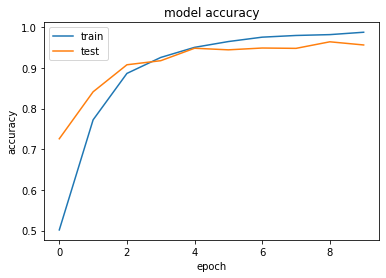

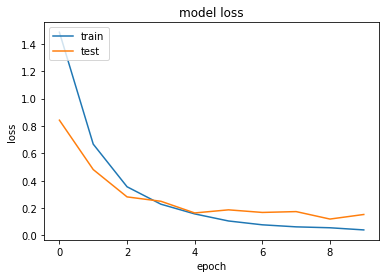

In [51]:
history2(history)

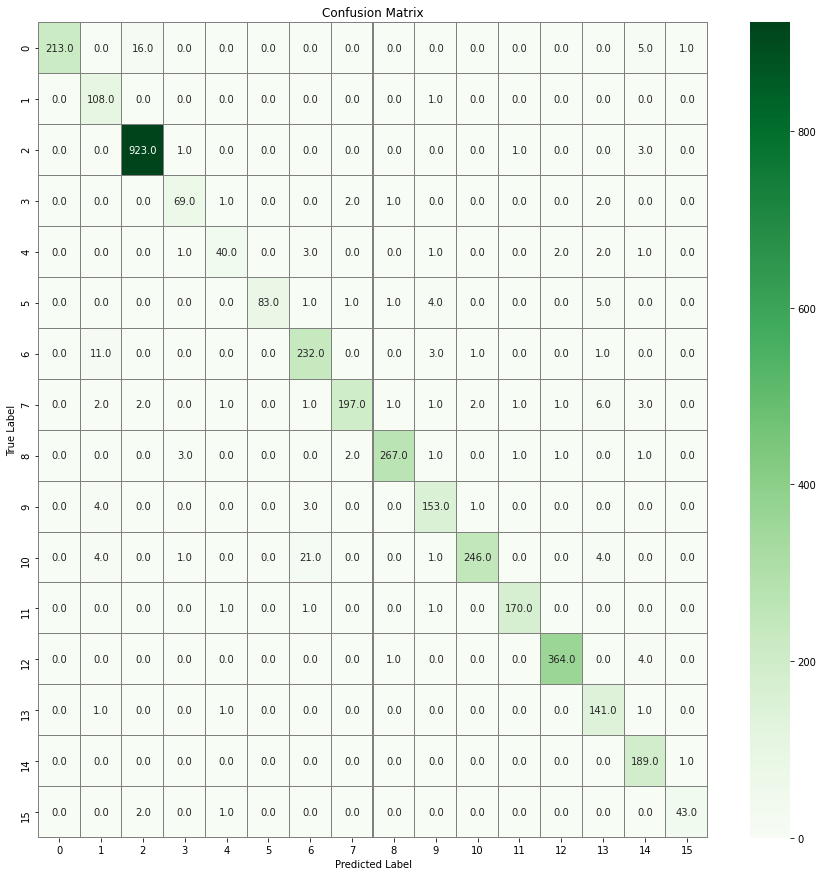

In [52]:
confussion_mat(model)